In [ ]:
!pip install networkx torch_geometric torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import networkx as nx
from torch_geometric.utils import to_networkx
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving manufacturing_test_data.csv to manufacturing_test_data.csv


In [ ]:
try:
    # Adjust path as needed
    data = pd.read_csv('manufacturing_test_data.csv')
    print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns")
except Exception as e:
    print(f"Error loading data: {e}")

# Display the first few rows
data.head()


Data loaded successfully with 293 rows and 7 columns


,Timestamps,M1_Status,M1_Worker_Count,M2_Status,M2_Worker_Count,M3_Status,M3_Worker_Count
0,17.58.07,Running,4,Stopped,0,Stopped,1
1,17.58.08,Running,5,Stopped,0,Stopped,0
2,17.58.09,Running,2,Stopped,1,Stopped,3
3,17.58.10,Running,2,Stopped,2,Stopped,3
4,17.58.11,Stopped,0,Stopped,0,Running,3


In [ ]:
print(data.columns)

Index(['Timestamps', 'M1_Status', 'M1_Worker_Count', 'M2_Status',
       'M2_Worker_Count', 'M3_Status', 'M3_Worker_Count'],
      dtype='object')


In [ ]:
print("Missing values per column:")
print(data.isnull().sum())

# Get basic statistics
print("\nBasic statistics:")
print(data.describe())

# Count machine statuses
print("\nMachine 1 Status Counts:")
print(data['M1_Status'].value_counts())
print("\nMachine 2 Status Counts:")
print(data['M2_Status'].value_counts())
print("\nMachine 3 Status Counts:")
print(data['M3_Status'].value_counts())

Missing values per column:
Timestamps         0
M1_Status          0
M1_Worker_Count    0
M2_Status          0
M2_Worker_Count    0
M3_Status          0
M3_Worker_Count    0
dtype: int64

Basic statistics:
       M1_Worker_Count  M2_Worker_Count  M3_Worker_Count
count       293.000000       293.000000       293.000000
mean          0.849829         1.361775         1.556314
std           1.516341         1.711816         1.724442
min           0.000000         0.000000         0.000000
25%           0.000000         0.000000         0.000000
50%           0.000000         0.000000         1.000000
75%           2.000000         3.000000         3.000000
max           5.000000         5.000000         5.000000

Machine 1 Status Counts:
M1_Status
Stopped    216
Running     77
Name: count, dtype: int64

Machine 2 Status Counts:
M2_Status
Stopped    193
Running    100
Name: count, dtype: int64

Machine 3 Status Counts:
M3_Status
Stopped    178
Running    115
Name: count, dtype: int64


Missing values in each column:
Timestamps         0
M1_Status          0
M1_Worker_Count    0
M2_Status          0
M2_Worker_Count    0
M3_Status          0
M3_Worker_Count    0
M1_Numeric         0
M2_Numeric         0
M3_Numeric         0
dtype: int64


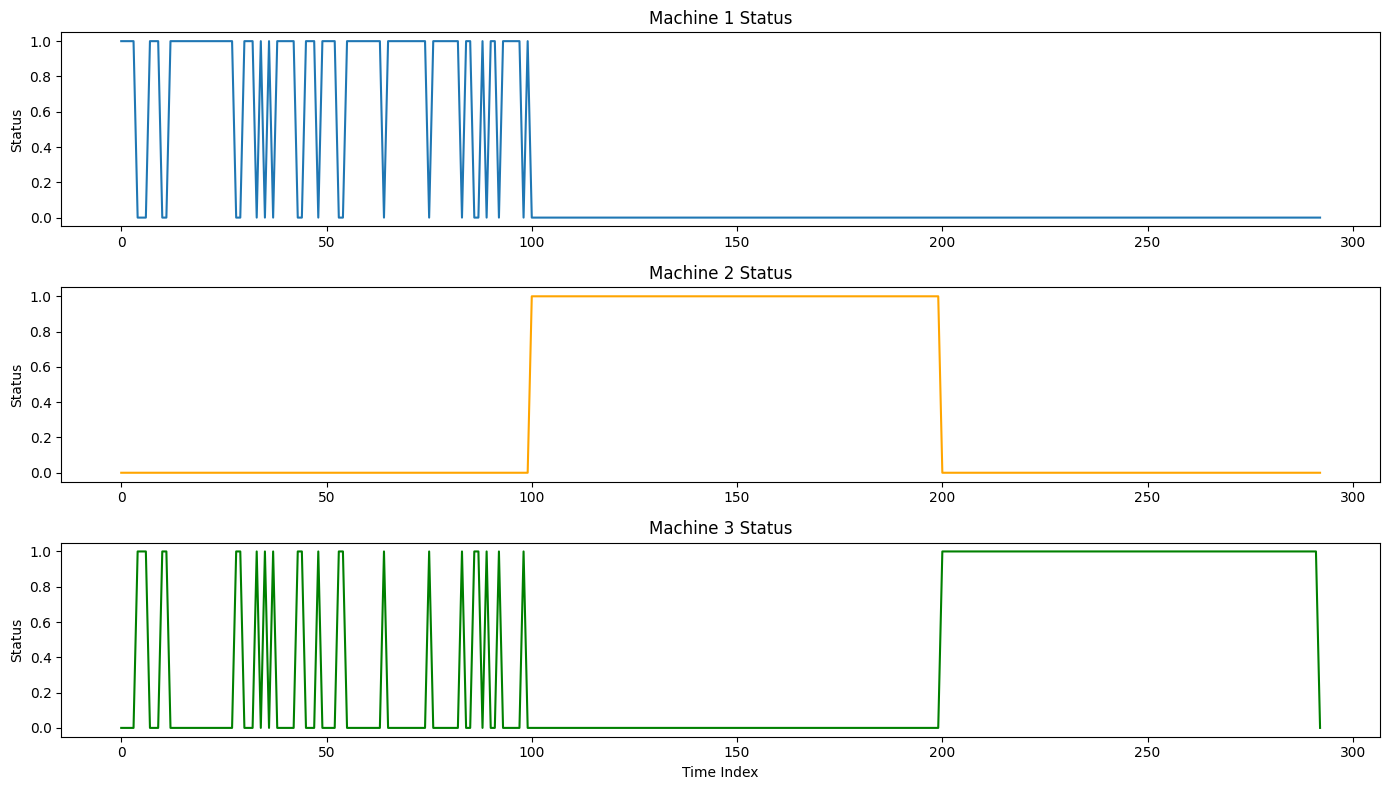

In [ ]:
# Convert timestamps to datetime format
data['Timestamps'] = pd.to_datetime(data['Timestamps'], format='%H.%M.%S').dt.time

# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Visualize machine status over time
plt.figure(figsize=(14, 8))

# Plot machine status (Running=1, Stopped=0)
plt.subplot(3, 1, 1)
plt.plot(range(len(data)), data['M1_Status'].map({'Running': 1, 'Stopped': 0}))
plt.title('Machine 1 Status')
plt.ylabel('Status')

plt.subplot(3, 1, 2)
plt.plot(range(len(data)), data['M2_Status'].map({'Running': 1, 'Stopped': 0}), color='orange')
plt.title('Machine 2 Status')
plt.ylabel('Status')

plt.subplot(3, 1, 3)
plt.plot(range(len(data)), data['M3_Status'].map({'Running': 1, 'Stopped': 0}), color='green')
plt.title('Machine 3 Status')
plt.ylabel('Status')
plt.xlabel('Time Index')

plt.tight_layout()
plt.show()

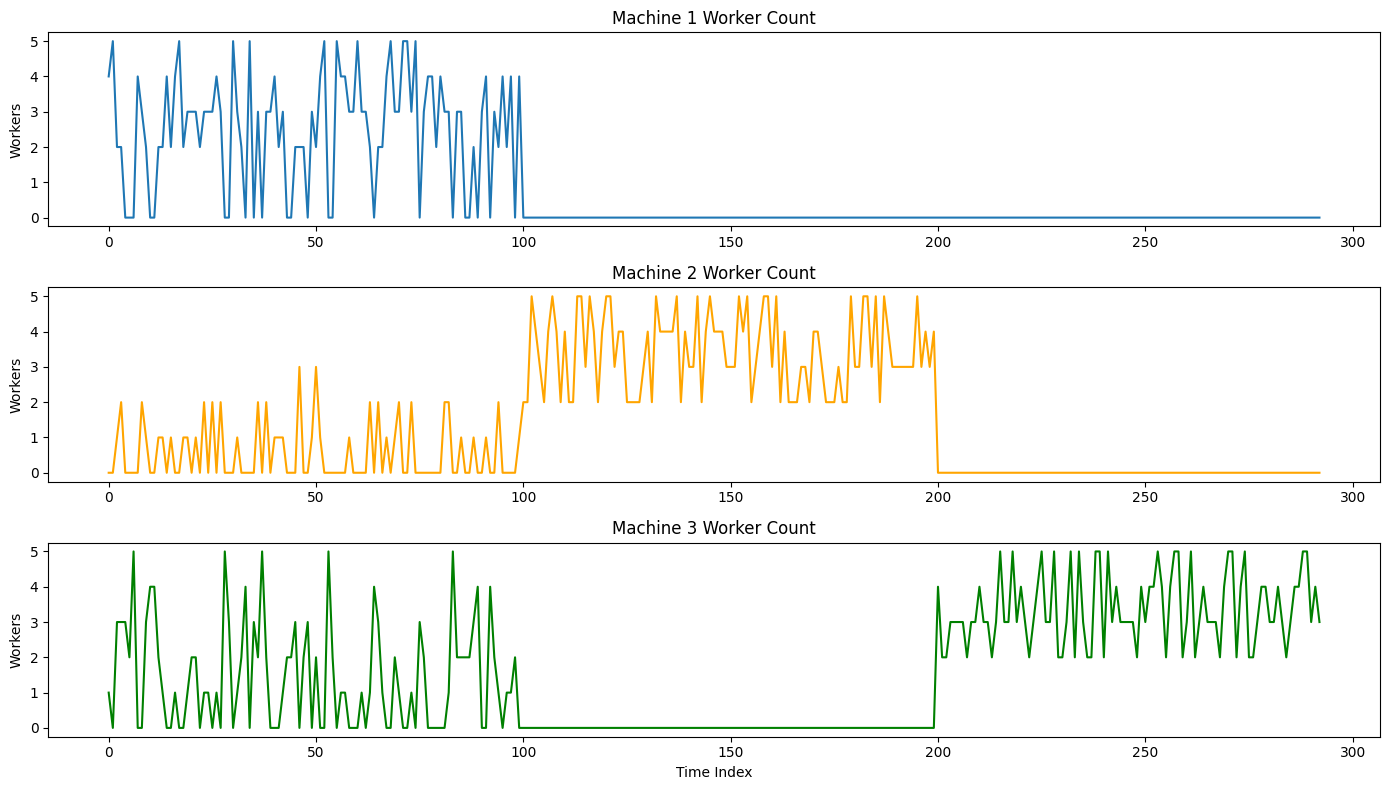

In [ ]:
# Visualize worker count for each machine
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(range(len(data)), data['M1_Worker_Count'])
plt.title('Machine 1 Worker Count')
plt.ylabel('Workers')

plt.subplot(3, 1, 2)
plt.plot(range(len(data)), data['M2_Worker_Count'], color='orange')
plt.title('Machine 2 Worker Count')
plt.ylabel('Workers')

plt.subplot(3, 1, 3)
plt.plot(range(len(data)), data['M3_Worker_Count'], color='green')
plt.title('Machine 3 Worker Count')
plt.ylabel('Workers')
plt.xlabel('Time Index')

plt.tight_layout()
plt.show()

In [ ]:
# Create feature matrix
# Convert status to numeric (Running=1, Stopped=0)
data['M1_Status_Numeric'] = data['M1_Status'].map({'Running': 1, 'Stopped': 0})
data['M2_Status_Numeric'] = data['M2_Status'].map({'Running': 1, 'Stopped': 0})
data['M3_Status_Numeric'] = data['M3_Status'].map({'Running': 1, 'Stopped': 0})

# Select features for the GNN
features = data[['M1_Status_Numeric', 'M1_Worker_Count',
                 'M2_Status_Numeric', 'M2_Worker_Count',
                 'M3_Status_Numeric', 'M3_Worker_Count']].values

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Feature shape:", features_scaled.shape)

Feature shape: (293, 6)


In [ ]:
# Define nodes and edges for the graph
# We'll have a node for each time point (row in the dataset)
# And edges connecting sequential time points

num_nodes = len(data)
edge_index = torch.tensor([[i, i+1] for i in range(num_nodes-1)], dtype=torch.long).t().contiguous()
x = torch.tensor(features_scaled, dtype=torch.float)

# Create PyTorch Geometric Data object
graph_data = Data(x=x, edge_index=edge_index)

print("Number of nodes:", graph_data.num_nodes)
print("Number of edges:", graph_data.num_edges)
print("Number of node features:", graph_data.num_node_features)

Number of nodes: 293
Number of edges: 292
Number of node features: 6


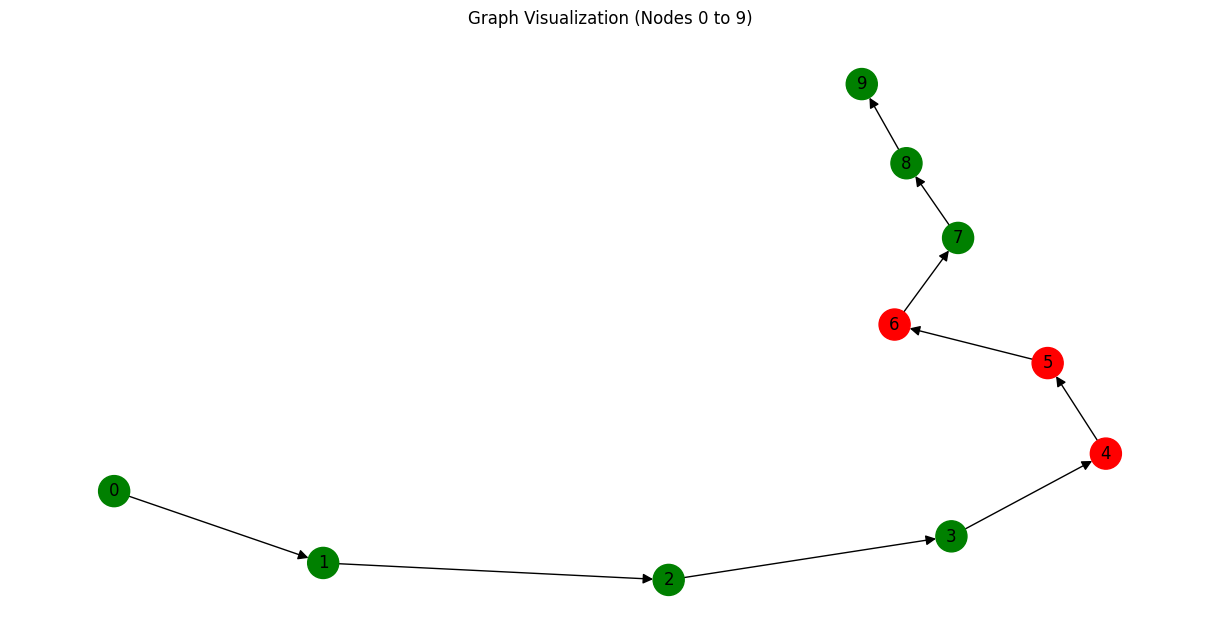

In [ ]:

# Function to visualize a subgraph of our time series graph
def visualize_graph_subset(data, start_idx, end_idx):
    # Create a subgraph
    sub_x = data.x[start_idx:end_idx]
    sub_edge_index = []

    for i in range(data.edge_index.shape[1]):
        src, dst = data.edge_index[0, i].item(), data.edge_index[1, i].item()
        if start_idx <= src < end_idx and start_idx <= dst < end_idx:
            sub_edge_index.append([src - start_idx, dst - start_idx])

    sub_edge_index = torch.tensor(sub_edge_index, dtype=torch.long).t().contiguous()

    # Create a NetworkX graph for visualization
    G = nx.DiGraph()

    # Add nodes
    for i in range(end_idx - start_idx):
        status = "Running" if sub_x[i, 0] > 0.5 else "Stopped"
        G.add_node(i, status=status)

    # Add edges
    for i in range(sub_edge_index.shape[1]):
        G.add_edge(sub_edge_index[0, i].item(), sub_edge_index[1, i].item())

    # Visualization
    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(G)

    # Color nodes based on machine status
    node_colors = ['green' if G.nodes[n]['status'] == 'Running' else 'red' for n in G.nodes()]

    nx.draw(G, pos, with_labels=True, node_color=node_colors,
            node_size=500, arrowsize=15, arrows=True)
    plt.title(f'Graph Visualization (Nodes {start_idx} to {end_idx-1})')
    plt.show()

# Visualize a small subset of the graph
visualize_graph_subset(graph_data, 0, 10)

In [ ]:
class GNNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
class GNNDecoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(GNNDecoder, self).__init__()
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, z):
        return self.linear(z)

In [ ]:
class GNNAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNAutoencoder, self).__init__()
        self.encoder = GNNEncoder(in_channels, hidden_channels)
        self.decoder = GNNDecoder(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Encode
        z = self.encoder(x, edge_index)
        # Decode
        x_hat = self.decoder(z)
        return x_hat, z

In [ ]:
# Set up model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = graph_data.num_node_features
hidden_channels = 32
out_channels = in_channels

# Create model
model = GNNAutoencoder(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

print(f"Using device: {device}")
print(f"Model: {model}")

Using device: cpu
Model: GNNAutoencoder(
  (encoder): GNNEncoder(
    (conv1): GCNConv(6, 32)
    (conv2): GCNConv(32, 32)
  )
  (decoder): GNNDecoder(
    (linear): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [ ]:
def train(model, data, optimizer, criterion, epochs):
    model.train()
    losses = []

    data = data.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        x_hat, _ = model(data.x, data.edge_index)

        # Compute loss
        loss = criterion(x_hat, data.x)

        # Backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

    return losses

Epoch 50/500, Loss: 0.233206
Epoch 100/500, Loss: 0.234654
Epoch 150/500, Loss: 0.228291
Epoch 200/500, Loss: 0.229979
Epoch 250/500, Loss: 0.230469
Epoch 300/500, Loss: 0.228246
Epoch 350/500, Loss: 0.219752
Epoch 400/500, Loss: 0.218964
Epoch 450/500, Loss: 0.223054
Epoch 500/500, Loss: 0.224038


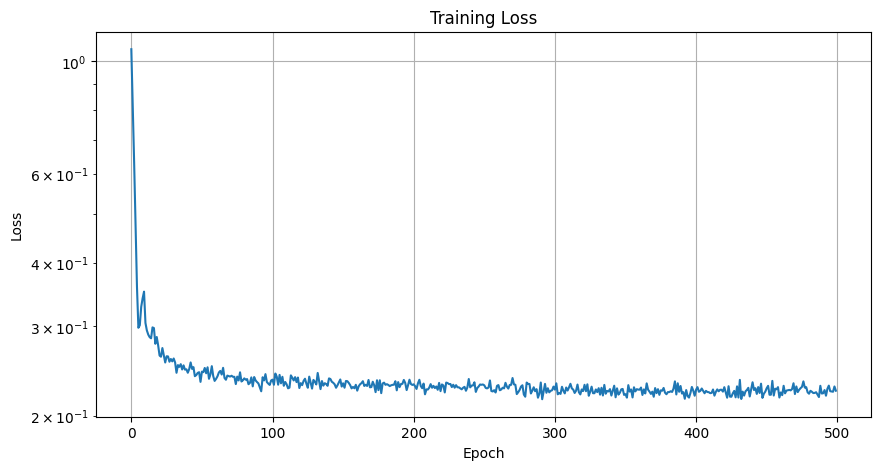

In [ ]:
# Train the model
epochs = 500
losses = train(model, graph_data, optimizer, criterion, epochs)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
def detect_anomalies(model, data, threshold_multiplier=3.0):
    model.eval()
    data = data.to(device)

    with torch.no_grad():
        # Get reconstructions
        x_hat, _ = model(data.x, data.edge_index)

        # Calculate reconstruction error
        reconstruction_error = F.mse_loss(x_hat, data.x, reduction='none').sum(dim=1)
        reconstruction_error = reconstruction_error.cpu().numpy()

        # Define threshold for anomalies (mean + std deviation * multiplier)
        threshold = reconstruction_error.mean() + threshold_multiplier * reconstruction_error.std()

        # Flag anomalies
        anomalies = reconstruction_error > threshold

        return reconstruction_error, anomalies, threshold

Threshold: 6.982864
Number of anomalies detected: 14 out of 293 (4.78%)


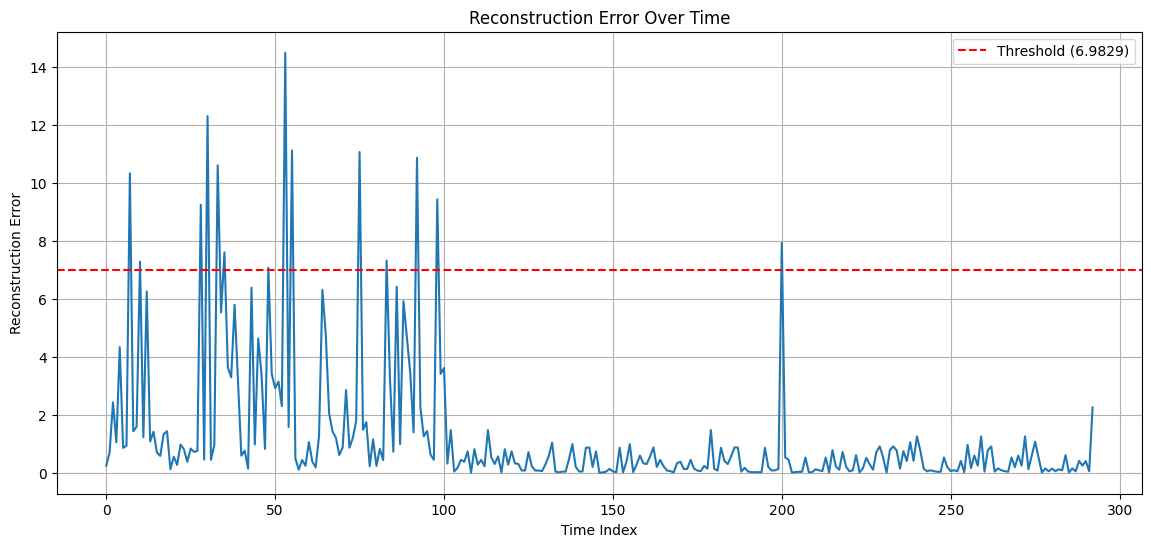

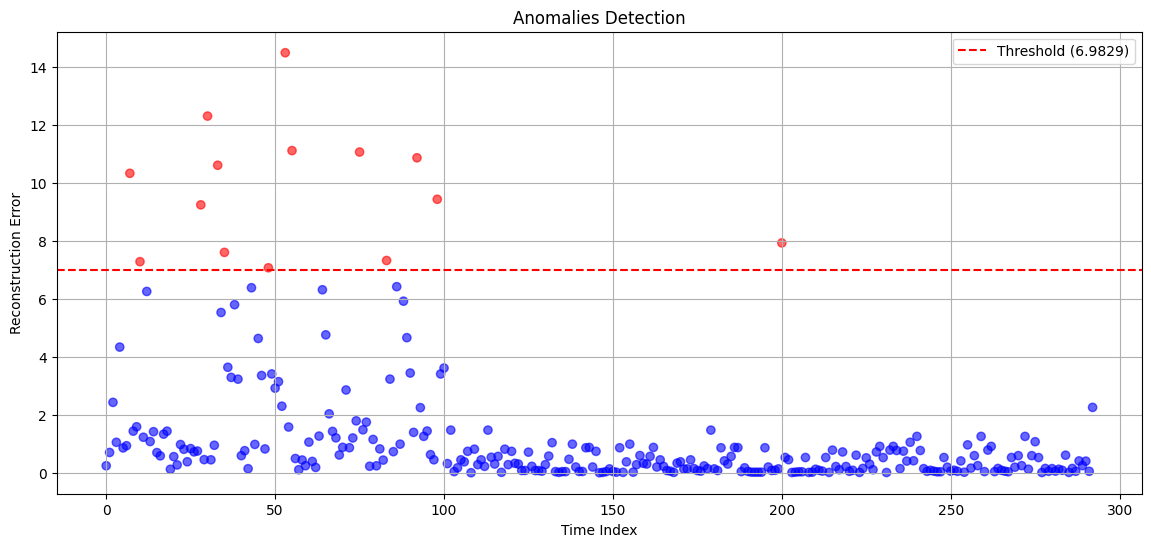

In [ ]:
# Detect anomalies
reconstruction_error, anomalies, threshold = detect_anomalies(model, graph_data, threshold_multiplier=2.5)

# Add reconstruction error to data frame
data['Reconstruction_Error'] = reconstruction_error
data['Is_Anomaly'] = anomalies

# Print anomaly statistics
print(f"Threshold: {threshold:.6f}")
print(f"Number of anomalies detected: {anomalies.sum()} out of {len(anomalies)} ({anomalies.sum()/len(anomalies)*100:.2f}%)")

# Visualize reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(range(len(data)), reconstruction_error)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Reconstruction Error Over Time')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

# Visualize anomalies
plt.figure(figsize=(14, 6))
plt.scatter(range(len(data)), reconstruction_error, c=['red' if a else 'blue' for a in anomalies], alpha=0.6)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Anomalies Detection')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

Task 1 anomalies: 13 out of 100 time points (13.00%)
Task 2 anomalies: 0 out of 100 time points (0.00%)
Task 3 anomalies: 1 out of 92 time points (1.09%)


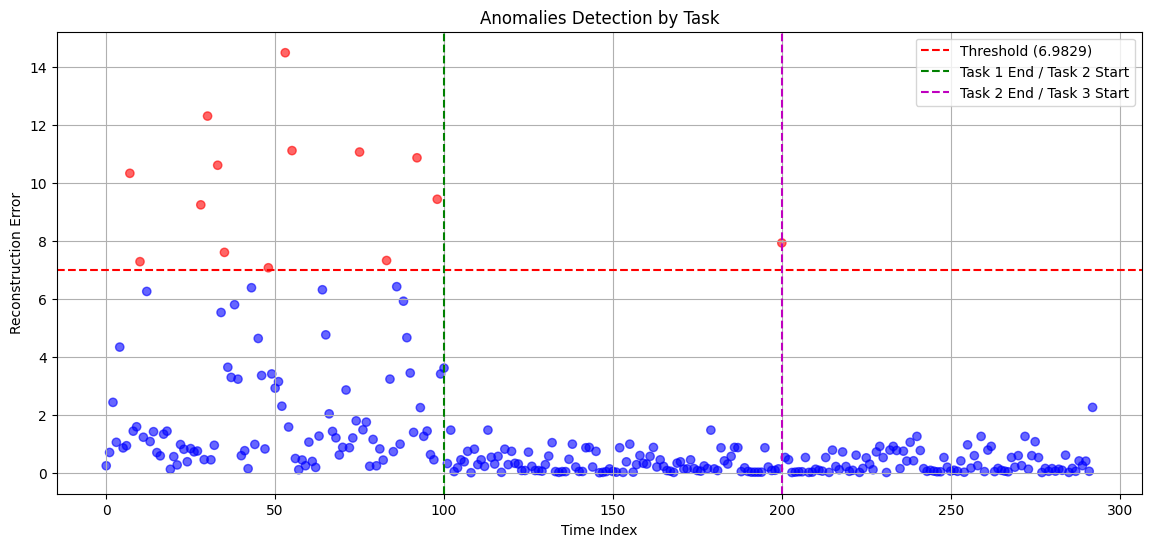

In [ ]:
# Define task time ranges
task1_range = (0, data.index[data['Timestamps'] == pd.to_datetime('17:59:47', format='%H:%M:%S').time()][0])
task2_range = (task1_range[1], data.index[data['Timestamps'] == pd.to_datetime('18:01:27', format='%H:%M:%S').time()][0])
task3_range = (task2_range[1], len(data) - 1)

# Analyze anomalies by task
task1_anomalies = anomalies[task1_range[0]:task1_range[1]].sum()
task2_anomalies = anomalies[task2_range[0]:task2_range[1]].sum()
task3_anomalies = anomalies[task3_range[0]:task3_range[1]].sum()

print(f"Task 1 anomalies: {task1_anomalies} out of {task1_range[1] - task1_range[0]} time points ({task1_anomalies/(task1_range[1] - task1_range[0])*100:.2f}%)")
print(f"Task 2 anomalies: {task2_anomalies} out of {task2_range[1] - task2_range[0]} time points ({task2_anomalies/(task2_range[1] - task2_range[0])*100:.2f}%)")
print(f"Task 3 anomalies: {task3_anomalies} out of {task3_range[1] - task3_range[0]} time points ({task3_anomalies/(task3_range[1] - task3_range[0])*100:.2f}%)")

# Visualize anomalies by task
plt.figure(figsize=(14, 6))
plt.scatter(range(len(data)), reconstruction_error, c=['red' if a else 'blue' for a in anomalies], alpha=0.6)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')

# Add task boundaries
plt.axvline(x=task1_range[1], color='g', linestyle='--', label='Task 1 End / Task 2 Start')
plt.axvline(x=task2_range[1], color='m', linestyle='--', label='Task 2 End / Task 3 Start')

plt.title('Anomalies Detection by Task')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

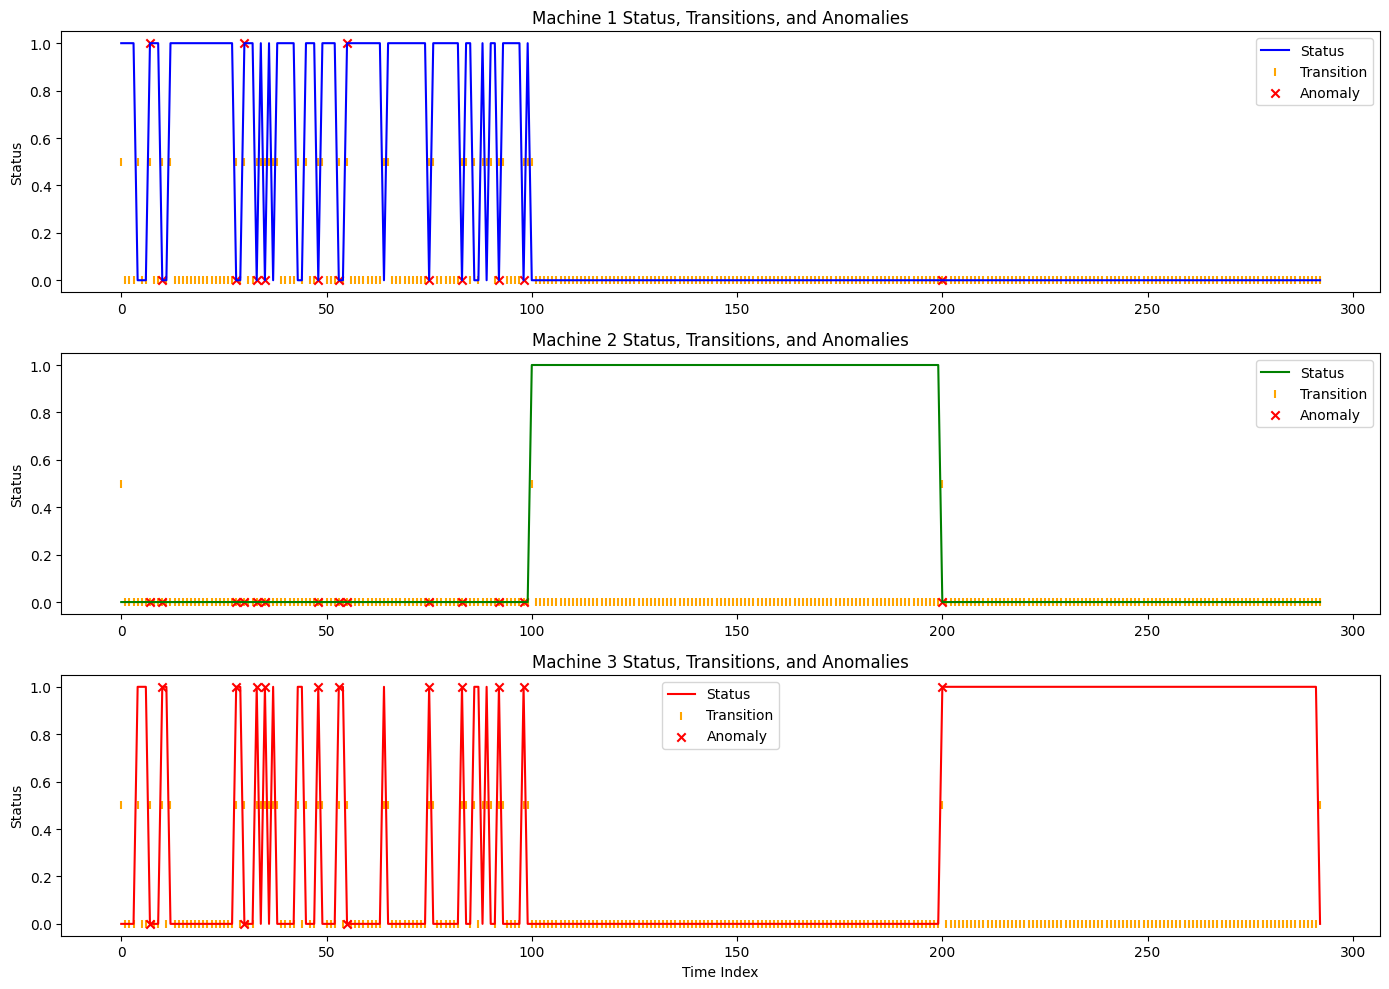

In [ ]:
# Analyze machine transitions
# Find time points where machine status changes
m1_transitions = (data['M1_Status_Numeric'].diff() != 0).astype(int)
m2_transitions = (data['M2_Status_Numeric'].diff() != 0).astype(int)
m3_transitions = (data['M3_Status_Numeric'].diff() != 0).astype(int)

# Plot transitions and anomalies
plt.figure(figsize=(14, 10))

# Machine 1 Status and Transitions
plt.subplot(3, 1, 1)
plt.plot(range(len(data)), data['M1_Status_Numeric'], 'b-', label='Status')
plt.scatter(range(len(data)), m1_transitions * 0.5, color='orange', marker='|', label='Transition')
plt.scatter(np.where(anomalies)[0], data['M1_Status_Numeric'][anomalies], color='red', marker='x', label='Anomaly')
plt.title('Machine 1 Status, Transitions, and Anomalies')
plt.ylabel('Status')
plt.legend()

# Machine 2 Status and Transitions
plt.subplot(3, 1, 2)
plt.plot(range(len(data)), data['M2_Status_Numeric'], 'g-', label='Status')
plt.scatter(range(len(data)), m2_transitions * 0.5, color='orange', marker='|', label='Transition')
plt.scatter(np.where(anomalies)[0], data['M2_Status_Numeric'][anomalies], color='red', marker='x', label='Anomaly')
plt.title('Machine 2 Status, Transitions, and Anomalies')
plt.ylabel('Status')
plt.legend()

# Machine 3 Status and Transitions
plt.subplot(3, 1, 3)
plt.plot(range(len(data)), data['M3_Status_Numeric'], 'r-', label='Status')
plt.scatter(range(len(data)), m3_transitions * 0.5, color='orange', marker='|', label='Transition')
plt.scatter(np.where(anomalies)[0], data['M3_Status_Numeric'][anomalies], color='red', marker='x', label='Anomaly')
plt.title('Machine 3 Status, Transitions, and Anomalies')
plt.ylabel('Status')
plt.xlabel('Time Index')
plt.legend()

plt.tight_layout()
plt.show()

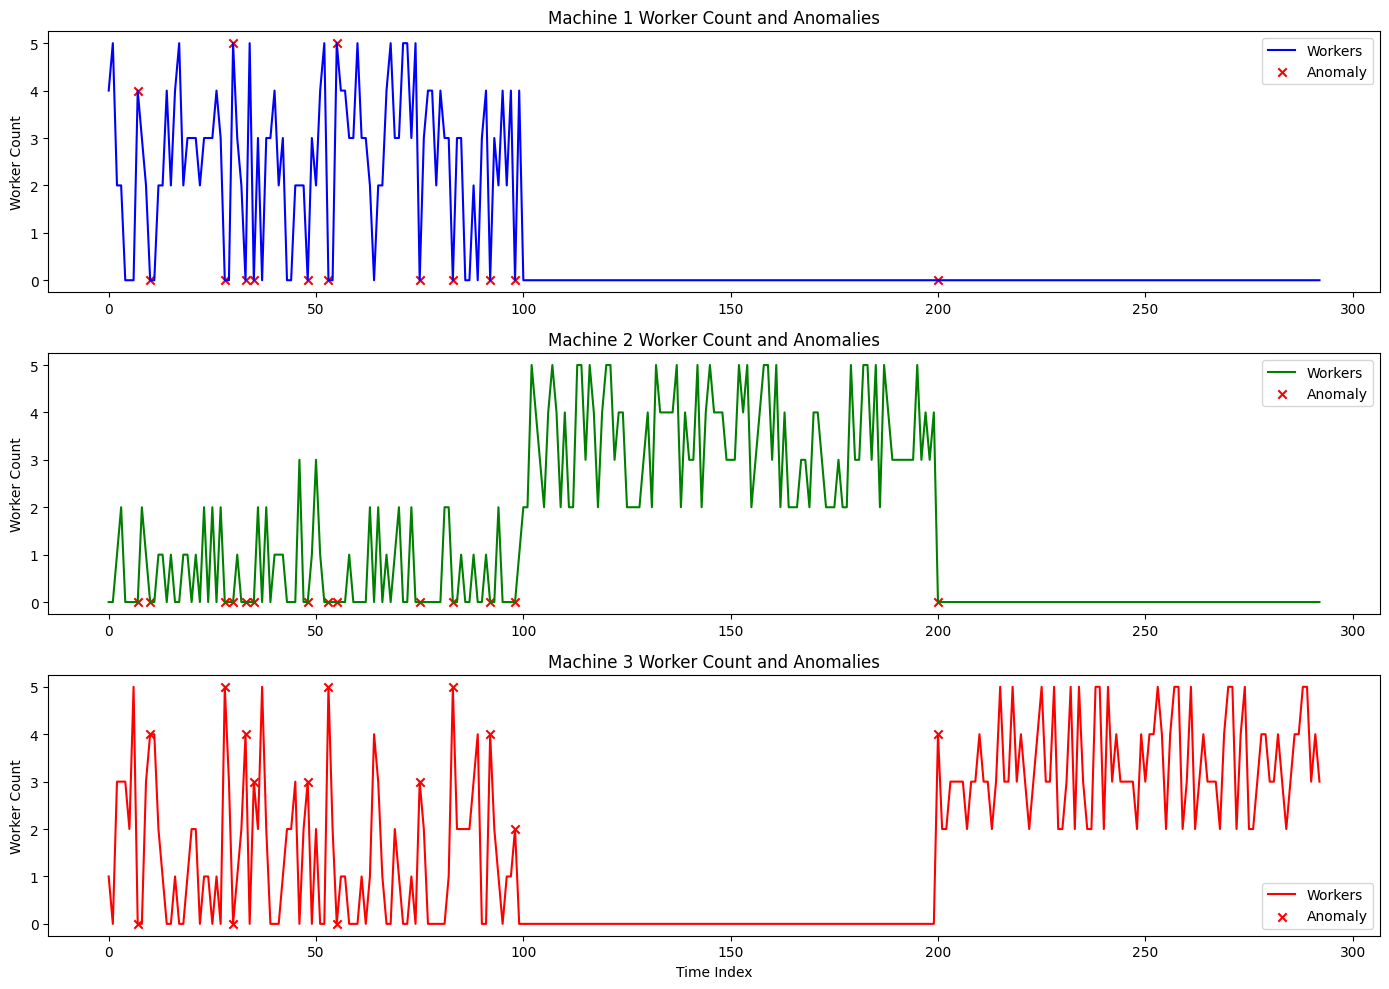

In [ ]:
# Analyze worker count patterns
# Plot worker counts and anomalies
plt.figure(figsize=(14, 10))

# Machine 1 Worker Count
plt.subplot(3, 1, 1)
plt.plot(range(len(data)), data['M1_Worker_Count'], 'b-', label='Workers')
plt.scatter(np.where(anomalies)[0], data['M1_Worker_Count'][anomalies], color='red', marker='x', label='Anomaly')
plt.title('Machine 1 Worker Count and Anomalies')
plt.ylabel('Worker Count')
plt.legend()

# Machine 2 Worker Count
plt.subplot(3, 1, 2)
plt.plot(range(len(data)), data['M2_Worker_Count'], 'g-', label='Workers')
plt.scatter(np.where(anomalies)[0], data['M2_Worker_Count'][anomalies], color='red', marker='x', label='Anomaly')
plt.title('Machine 2 Worker Count and Anomalies')
plt.ylabel('Worker Count')
plt.legend()

# Machine 3 Worker Count
plt.subplot(3, 1, 3)
plt.plot(range(len(data)), data['M3_Worker_Count'], 'r-', label='Workers')
plt.scatter(np.where(anomalies)[0], data['M3_Worker_Count'][anomalies], color='red', marker='x', label='Anomaly')
plt.title('Machine 3 Worker Count and Anomalies')
plt.ylabel('Worker Count')
plt.xlabel('Time Index')
plt.legend()

plt.tight_layout()
plt.show()

Machine 1 and 3 running simultaneously: 0 time points with 0 anomalies
Machine 2 and 3 running simultaneously: 0 time points with 0 anomalies
Machine 1 and 2 running simultaneously: 0 time points with 0 anomalies


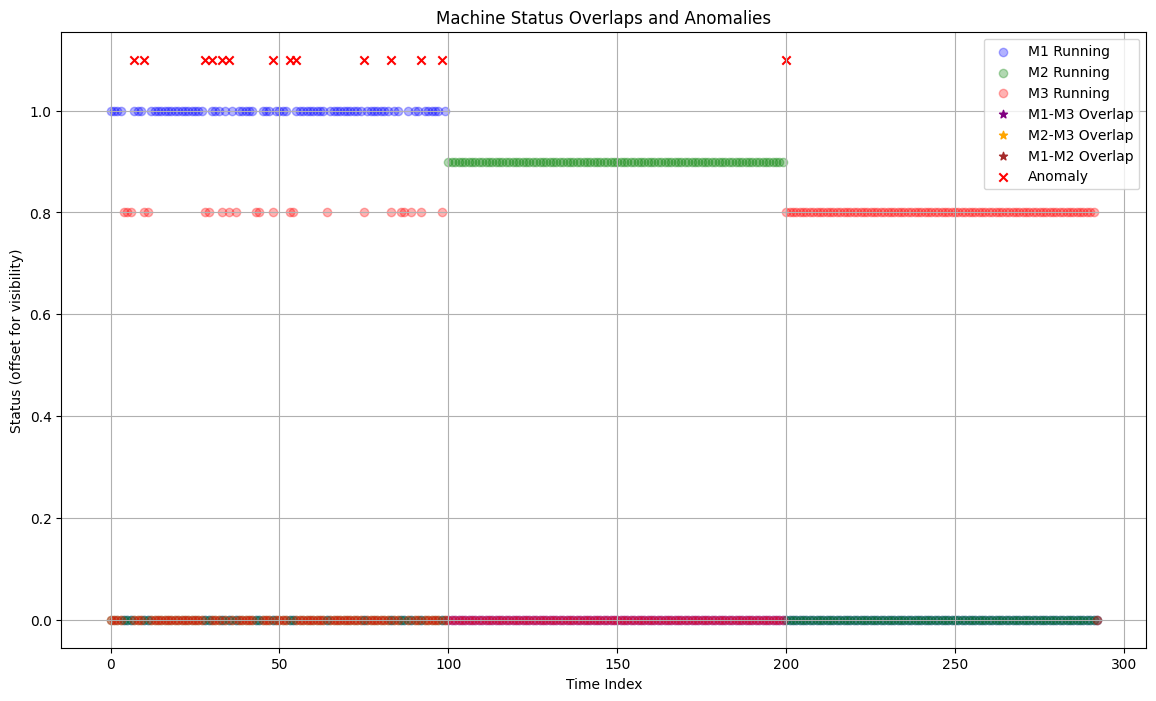

In [ ]:
# Analyze task interactions (machine overlaps)
# Create flags for when machines are running simultaneously
m1_m3_overlap = (data['M1_Status_Numeric'] == 1) & (data['M3_Status_Numeric'] == 1)
m2_m3_overlap = (data['M2_Status_Numeric'] == 1) & (data['M3_Status_Numeric'] == 1)
m1_m2_overlap = (data['M1_Status_Numeric'] == 1) & (data['M2_Status_Numeric'] == 1)

# Check anomalies in overlaps
anomalies_in_m1_m3 = (anomalies & m1_m3_overlap).sum()
anomalies_in_m2_m3 = (anomalies & m2_m3_overlap).sum()
anomalies_in_m1_m2 = (anomalies & m1_m2_overlap).sum()

print(f"Machine 1 and 3 running simultaneously: {m1_m3_overlap.sum()} time points with {anomalies_in_m1_m3} anomalies")
print(f"Machine 2 and 3 running simultaneously: {m2_m3_overlap.sum()} time points with {anomalies_in_m2_m3} anomalies")
print(f"Machine 1 and 2 running simultaneously: {m1_m2_overlap.sum()} time points with {anomalies_in_m1_m2} anomalies")

# Visualize overlaps
plt.figure(figsize=(14, 8))
plt.scatter(range(len(data)), data['M1_Status_Numeric'], color='blue', alpha=0.3, label='M1 Running')
plt.scatter(range(len(data)), data['M2_Status_Numeric'] * 0.9, color='green', alpha=0.3, label='M2 Running')
plt.scatter(range(len(data)), data['M3_Status_Numeric'] * 0.8, color='red', alpha=0.3, label='M3 Running')

# Highlight overlaps
plt.scatter(np.where(m1_m3_overlap)[0], [0.9] * m1_m3_overlap.sum(), color='purple', marker='*', label='M1-M3 Overlap')
plt.scatter(np.where(m2_m3_overlap)[0], [0.8] * m2_m3_overlap.sum(), color='orange', marker='*', label='M2-M3 Overlap')
plt.scatter(np.where(m1_m2_overlap)[0], [0.7] * m1_m2_overlap.sum(), color='brown', marker='*', label='M1-M2 Overlap')

# Highlight anomalies
plt.scatter(np.where(anomalies)[0], [1.1] * anomalies.sum(), color='red', marker='x', label='Anomaly')

plt.title('Machine Status Overlaps and Anomalies')
plt.xlabel('Time Index')
plt.ylabel('Status (offset for visibility)')
plt.legend()
plt.grid(True)
plt.show()

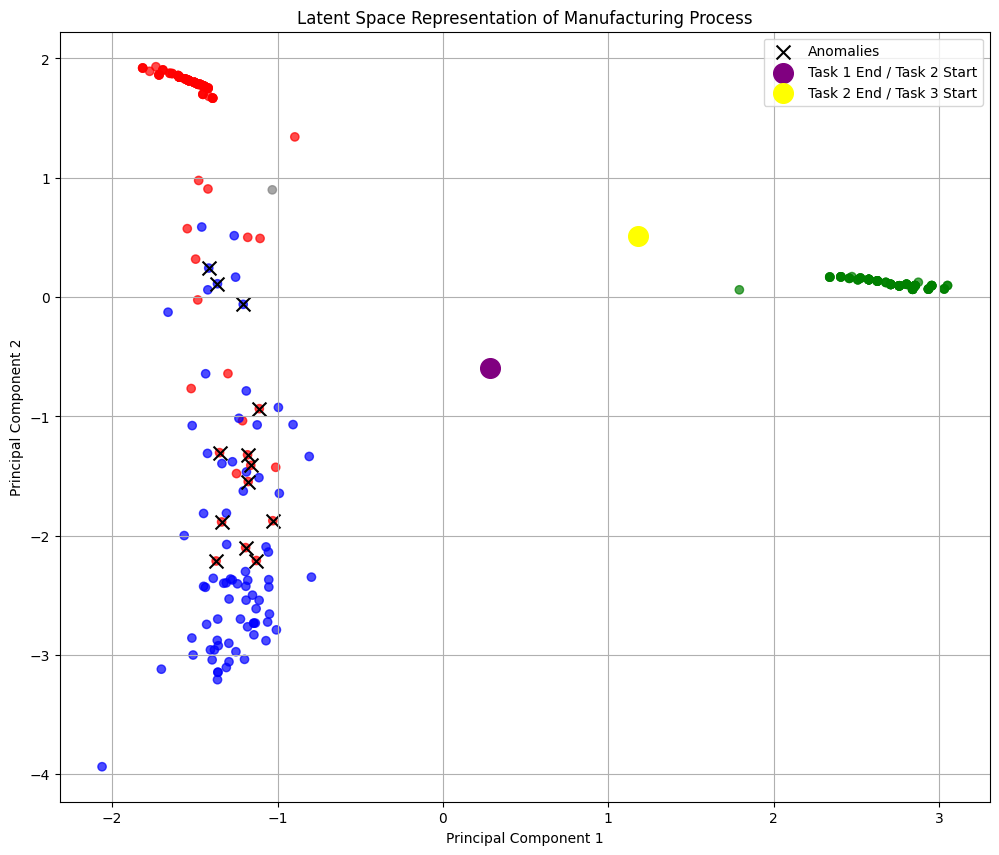

Cluster distribution in Task 1:
Cluster
2    84
1    16
Name: count, dtype: int64

Cluster distribution in Task 2:
Cluster
0    99
2     1
Name: count, dtype: int64

Cluster distribution in Task 3:
Cluster
1    91
0     1
Name: count, dtype: int64


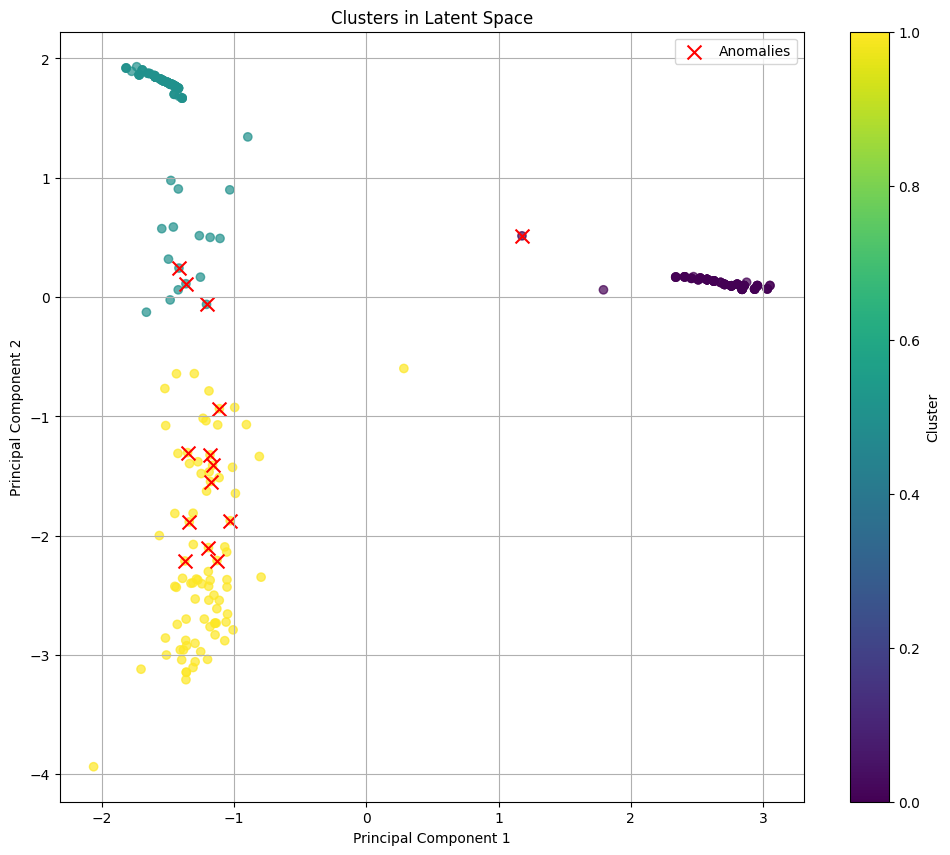

In [ ]:
# Extract high-level patterns from the latent space
model.eval()
graph_data = graph_data.to(device)

with torch.no_grad():
    _, latent_embeddings = model(graph_data.x, graph_data.edge_index)
    latent_embeddings = latent_embeddings.cpu().numpy()

# Dimensionality reduction for visualization (PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_embeddings)

# Visualize latent space
plt.figure(figsize=(12, 10))

# Color points based on machine status (which machine is running)
colors = []
for i in range(len(data)):
    if data['M1_Status_Numeric'][i] == 1:
        colors.append('blue')
    elif data['M2_Status_Numeric'][i] == 1:
        colors.append('green')
    elif data['M3_Status_Numeric'][i] == 1:
        colors.append('red')
    else:
        colors.append('gray')

# Create scatter plot
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, alpha=0.7)

# Highlight anomalies
plt.scatter(latent_2d[anomalies, 0], latent_2d[anomalies, 1],
            color='black', marker='x', s=100, label='Anomalies')

# Add task boundaries in the latent space
plt.scatter(latent_2d[task1_range[1], 0], latent_2d[task1_range[1], 1],
            color='purple', marker='o', s=200, label='Task 1 End / Task 2 Start')
plt.scatter(latent_2d[task2_range[1], 0], latent_2d[task2_range[1], 1],
            color='yellow', marker='o', s=200, label='Task 2 End / Task 3 Start')

plt.title('Latent Space Representation of Manufacturing Process')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Analyze patterns in latent space
# K-means clustering on latent space
from sklearn.cluster import KMeans

n_clusters = 3  # For the 3 different tasks
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_embeddings)

# Add cluster information to the dataframe
data['Cluster'] = clusters

# Analyze clusters by task
task1_clusters = data['Cluster'][task1_range[0]:task1_range[1]].value_counts()
task2_clusters = data['Cluster'][task2_range[0]:task2_range[1]].value_counts()
task3_clusters = data['Cluster'][task3_range[0]:task3_range[1]].value_counts()

print("Cluster distribution in Task 1:")
print(task1_clusters)
print("\nCluster distribution in Task 2:")
print(task2_clusters)
print("\nCluster distribution in Task 3:")
print(task3_clusters)

# Visualize clusters in latent space
plt.figure(figsize=(12, 10))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.scatter(latent_2d[anomalies, 0], latent_2d[anomalies, 1],
            color='red', marker='x', s=100, label='Anomalies')
plt.title('Clusters in Latent Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

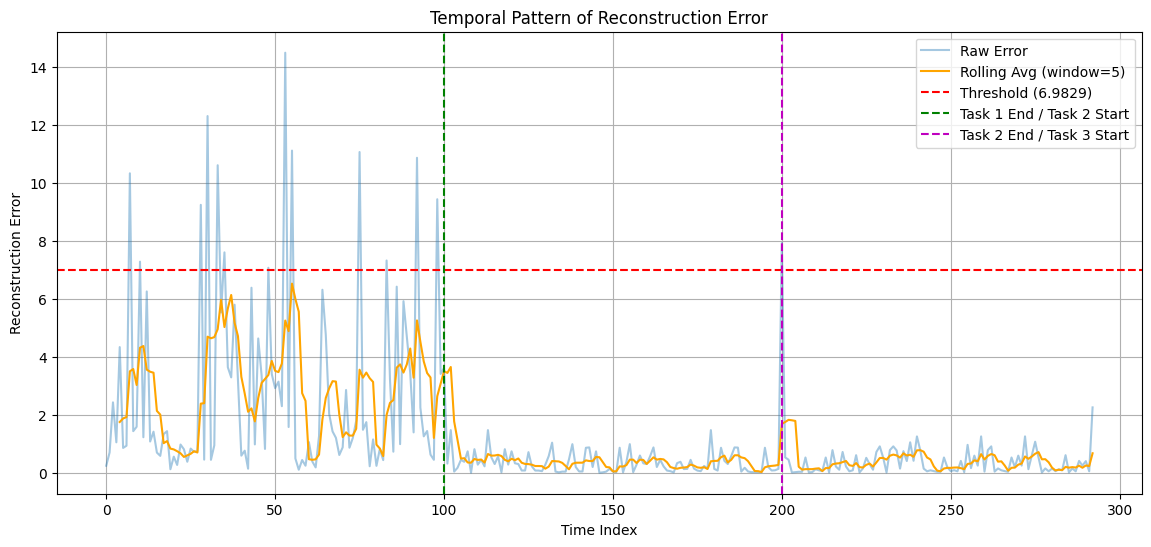

In [ ]:
# Analyze temporal patterns
# Create a sliding window of reconstruction errors
window_size = 5
rolling_error = pd.Series(reconstruction_error).rolling(window=window_size).mean()

# Plot rolling average of reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(range(len(data)), reconstruction_error, alpha=0.4, label='Raw Error')
plt.plot(range(len(data)), rolling_error, color='orange', label=f'Rolling Avg (window={window_size})')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')

# Add task boundaries
plt.axvline(x=task1_range[1], color='g', linestyle='--', label='Task 1 End / Task 2 Start')
plt.axvline(x=task2_range[1], color='m', linestyle='--', label='Task 2 End / Task 3 Start')

plt.title('Temporal Pattern of Reconstruction Error')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

Found 10 potential adaptive behavior instances (M1 -> M3 -> M1)
Number of adaptive behaviors flagged as anomalies: 7 out of 10


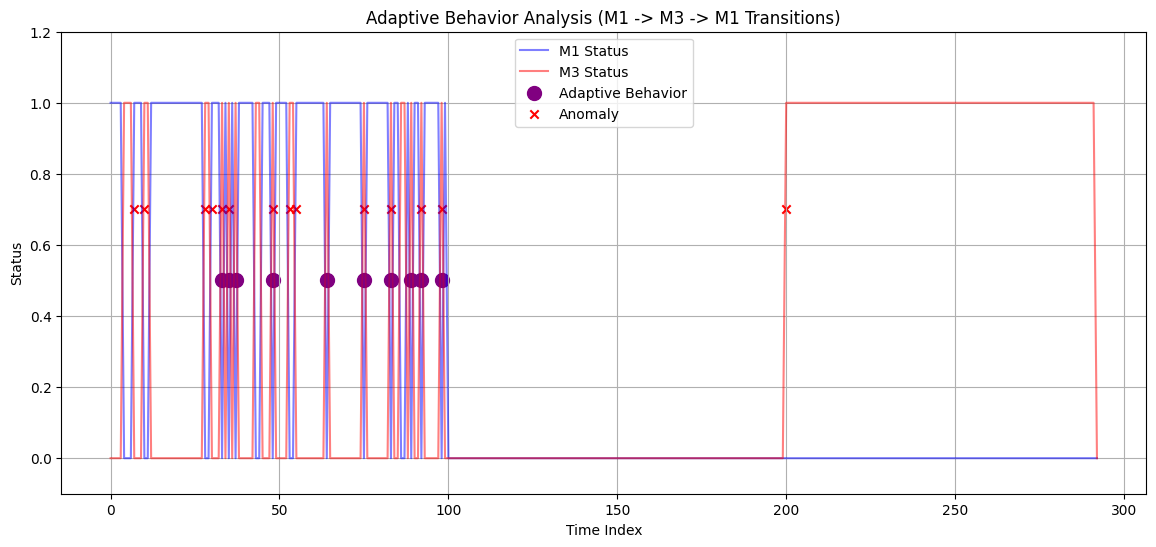

In [ ]:
# Analyze adaptive behavior mentioned in the SOP
# "If the material density is too high during Task 1 (Machine 1 processing),
# the material is temporarily processed in Machine 3 before resuming Task 1."

# Find instances where M1 is running, then M3 runs, then M1 resumes
m1_to_m3_transitions = []

for i in range(1, len(data) - 1):
    if (data['M1_Status_Numeric'][i-1] == 1 and
        data['M1_Status_Numeric'][i] == 0 and
        data['M3_Status_Numeric'][i] == 1 and
        data['M1_Status_Numeric'][i+1] == 1):
        m1_to_m3_transitions.append(i)

print(f"Found {len(m1_to_m3_transitions)} potential adaptive behavior instances (M1 -> M3 -> M1)")

# Check if these transitions are flagged as anomalies
adaptive_and_anomaly = [i for i in m1_to_m3_transitions if anomalies[i]]
print(f"Number of adaptive behaviors flagged as anomalies: {len(adaptive_and_anomaly)} out of {len(m1_to_m3_transitions)}")

# Visualize these adaptive behaviors
plt.figure(figsize=(14, 6))
plt.plot(range(len(data)), data['M1_Status_Numeric'], 'b-', label='M1 Status', alpha=0.5)
plt.plot(range(len(data)), data['M3_Status_Numeric'], 'r-', label='M3 Status', alpha=0.5)
plt.scatter(m1_to_m3_transitions, [0.5] * len(m1_to_m3_transitions),
            color='purple', marker='o', s=100, label='Adaptive Behavior')
plt.scatter(np.where(anomalies)[0], [0.7] * anomalies.sum(),
            color='red', marker='x', label='Anomaly')

plt.title('Adaptive Behavior Analysis (M1 -> M3 -> M1 Transitions)')
plt.xlabel('Time Index')
plt.ylabel('Status')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.2)
plt.show()

Original anomalies: 14
Refined anomalies (excluding adaptive behaviors): 7


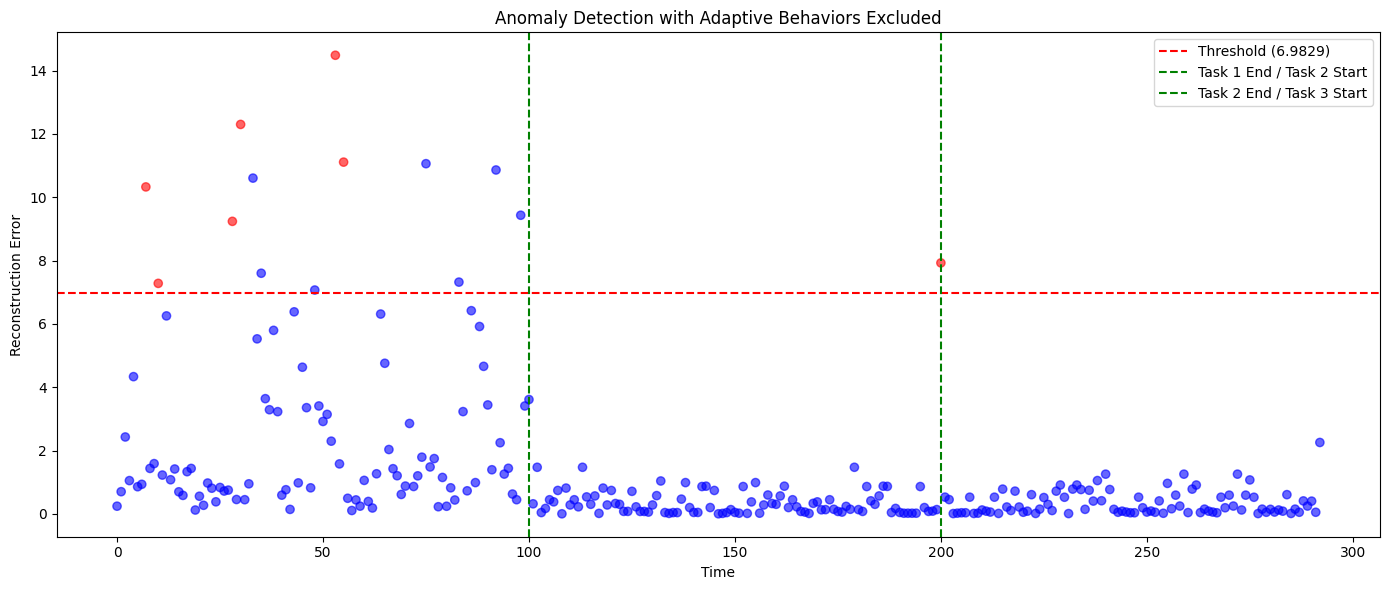

Saved 7 refined anomalies to file


In [ ]:
# Refine anomaly detection by considering known adaptive behaviors
# Create a mask for known adaptive behaviors
adaptive_behavior_mask = np.zeros(len(data), dtype=bool)
for i in m1_to_m3_transitions:
    # Mark a window around each adaptive behavior
    start_idx = max(0, i - 2)
    end_idx = min(len(data), i + 3)
    adaptive_behavior_mask[start_idx:end_idx] = True

# Remove adaptive behaviors from anomalies
refined_anomalies = anomalies & ~adaptive_behavior_mask
print(f"Original anomalies: {anomalies.sum()}")
print(f"Refined anomalies (excluding adaptive behaviors): {refined_anomalies.sum()}")

# Visualize refined anomalies
plt.figure(figsize=(14, 6))
plt.scatter(range(len(data)), reconstruction_error, c=['red' if a else 'blue' for a in refined_anomalies], alpha=0.6)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
# Add task boundaries
plt.axvline(x=task1_range[1], color='g', linestyle='--', label='Task 1 End / Task 2 Start')
plt.axvline(x=task2_range[1], color='g', linestyle='--', label='Task 2 End / Task 3 Start')
plt.title('Anomaly Detection with Adaptive Behaviors Excluded')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Save marked anomalies for further analysis
anomaly_indices = np.where(refined_anomalies)[0]
anomaly_scores = reconstruction_error[refined_anomalies]
anomaly_data = pd.DataFrame({
    'index': anomaly_indices,
    'score': anomaly_scores
})
anomaly_data.to_csv('refined_anomalies.csv', index=False)
print(f"Saved {len(anomaly_indices)} refined anomalies to file")